In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network

## FIFA dataset 

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import sys
#import numpy as np
import pandas as pd

from collections.abc import Callable
from typing import Literal

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [3]:
torch.cuda.is_available()

False

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
print(fn_plot_torch_hist.__doc__)

None


In [6]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


In [7]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../..\Classwork/input'
outDir = './output'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE)

EPOCHS = 2001 # number of epochs
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Read FIFA 2019 data set

### dataset loading and cleaning

In [8]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [9]:
for col in data_df.columns:
    print(f'{col} : {data_df[col].unique()}')

Unnamed: 0 : [    0     1     2 ... 18204 18205 18206]
ID : [158023  20801 190871 ... 241638 246268 246269]
Name : ['L. Messi' 'Cristiano Ronaldo' 'Neymar Jr' ... 'B. Worman'
 'D. Walker-Rice' 'G. Nugent']
Age : [31 33 26 27 32 25 29 28 24 30 19 40 22 23 34 35 36 37 21 18 20 39 41 17
 38 45 42 16 44]
Photo : ['https://cdn.sofifa.org/players/4/19/158023.png'
 'https://cdn.sofifa.org/players/4/19/20801.png'
 'https://cdn.sofifa.org/players/4/19/190871.png' ...
 'https://cdn.sofifa.org/players/4/19/241638.png'
 'https://cdn.sofifa.org/players/4/19/246268.png'
 'https://cdn.sofifa.org/players/4/19/246269.png']
Nationality : ['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Algeria' 'Austria'
 'Greece' 'Chile' 'Sweden' 'Korea Republic' 'Finland' 'Guinea'
 'Montenegro' 'Armenia' '

In [10]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,18207.0,9103.000000,5256.052511,0.0,4551.5,9103.0,13654.5,18206.0
ID,18207.0,214298.338606,29965.244204,16.0,200315.5,221759.0,236529.5,246620.0
Age,18207.0,25.122206,4.669943,16.0,21.0,25.0,28.0,45.0
Overall,18207.0,66.238699,6.908930,46.0,62.0,66.0,71.0,94.0
Potential,18207.0,71.307299,6.136496,48.0,67.0,71.0,75.0,95.0
Special,18207.0,1597.809908,272.586016,731.0,1457.0,1635.0,1787.0,2346.0
International Reputation,18159.0,1.113222,0.394031,1.0,1.0,1.0,1.0,5.0
Weak Foot,18159.0,2.947299,0.660456,1.0,3.0,3.0,3.0,5.0
Skill Moves,18159.0,2.361308,0.756164,1.0,2.0,2.0,3.0,5.0
Jersey Number,18147.0,19.546096,15.947765,1.0,8.0,17.0,26.0,99.0


In [11]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


### Target = positions 

In [12]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [13]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


### Data spliting and scalling

In [14]:
labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

X = data_df.drop('Position',axis=1)
y = data_df['Position'].to_numpy()

# splitting in train ans test datasets
X_train, X_test , y_train, y_test= train_test_split(X,y,
                                     stratify=data_df['Position'],
                                     test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE )

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14517, 33), (3630, 33), (14517,), (3630,))

In [15]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

## Define model 

In [16]:
input_dim = X_train.shape[1]

model = nn.Sequential(nn.Linear(input_dim,18),
                     nn.Tanh(),
                     nn.Linear(18,4)).to(device = device)

In [17]:
print(model)

Sequential(
  (0): Linear(in_features=33, out_features=18, bias=True)
  (1): Tanh()
  (2): Linear(in_features=18, out_features=4, bias=True)
)


In [18]:
list(model.parameters())

[Parameter containing:
 tensor([[ 9.2062e-02, -4.3501e-02, -1.4794e-01,  1.0717e-02,  1.6225e-01,
          -7.7643e-02, -5.6670e-02,  1.3613e-01, -2.4222e-02, -6.6486e-02,
          -3.5062e-02,  6.3746e-03, -1.4182e-01, -4.9749e-02,  1.6879e-01,
          -3.7317e-02,  1.5855e-01, -6.7960e-02, -7.0020e-02, -5.1887e-02,
          -1.5565e-01, -1.0485e-01,  1.0520e-01, -1.3059e-01,  5.9465e-02,
           1.6379e-01, -2.2121e-02,  7.6153e-02,  8.1313e-02, -1.2426e-01,
          -6.7123e-02, -5.4516e-02,  1.6798e-01],
         [-1.5537e-01,  1.0537e-01,  1.6350e-01,  1.3764e-01,  7.4190e-02,
           7.7494e-02, -9.2818e-03,  8.7583e-02,  1.5868e-01, -5.5976e-02,
           1.6820e-01,  2.7665e-02, -1.2210e-01, -1.2494e-01,  6.1399e-02,
          -2.4561e-02, -7.6685e-02,  8.8150e-02, -9.1821e-02, -8.3203e-02,
           3.2539e-02, -3.1431e-02, -1.4688e-01, -5.2295e-02, -6.1178e-02,
          -7.4187e-02,  1.3552e-01, -2.6404e-02, -1.0632e-01,  5.1576e-02,
           2.9993e-02, -1.3

In [19]:
print(f'Num parametrs : {len(list(model.parameters()))}')
print(f'Layer 1 : Wieghts : {(list(model.parameters()))[0].shape}')
print(f'Layer 1 : Bias : {(list(model.parameters()))[1].shape}')
print(f'Layer 2 : Wieghts : {(list(model.parameters()))[1].shape}')
print(f'Layer 2 : Bias : {(list(model.parameters()))[3].shape}')

Num parametrs : 4
Layer 1 : Wieghts : torch.Size([18, 33])
Layer 1 : Bias : torch.Size([18])
Layer 2 : Wieghts : torch.Size([18])
Layer 2 : Bias : torch.Size([4])


## Convert data into tensor

In [20]:
train_X = torch.tensor(X_train, dtype = torch.float32, device = device)
train_y = torch.tensor(y_train, dtype = torch.int64, device = device)

test_X = torch.tensor(X_test, dtype = torch.float32, device = device)
test_y = torch.tensor(y_test, dtype = torch.int64, device = device)

## Testing model for a data

In [21]:
pred_prob = model(train_X[:1])  ## making prediction (gives tensor that requires gradients)
pred_prob.detach().numpy() ## convert to numpy by detaching so as to not using gradients

array([[-0.40813166, -0.18573728,  0.13504392, -0.10311078]],
      dtype=float32)

## Training model

In [22]:
## Loss function
loss_fn = nn.CrossEntropyLoss()

## Optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=ALPHA)

In [23]:
### Some lists to collect data
loss = []
tloss = []
n_epoch = []
acc = []
tacc = []

## iterations
for epoch in range(EPOCHS):
    
    model.train() ### set model in training mode
    
    predict_prob = model(train_X) ## make prediction
    
    curr_loss = loss_fn(predict_prob , train_y) ## Calculate loss
    
    ### -----------
    ### Back Prop Step
    ### -----------
    
    optimizer.zero_grad() ### forget gradients for previous loop
    curr_loss.backward() ## asssign loss calculated
    optimizer.step() ## calculate gradients and take step to reduce loss
    
    loss.append ( curr_loss.data.item() ) # append to loss list
    
    _, y_pred = torch.max(predict_prob, 1) # get predicted class from the probabilities
        
    curr_acc = accuracy_score( y_train, y_pred.data) # move to CPU if  device = 'cpu' --> y_pred.data.cpu()
    
    acc.append(curr_acc) # append to accuracy list
    
    
    
    model.eval() # evaluation mode, prevent from learning
    
    predict_prob_tst = model(test_X) # make predictions on test data
    
    tcurr_loss = loss_fn( predict_prob_tst, test_y)
    
    tloss.append( tcurr_loss.data.item())  # append to loss list
    
    _, y_pred = torch.max(predict_prob_tst, 1) # get predicted class from the probabilities
    
    tcurr_acc = accuracy_score( y_test, y_pred.data.cpu()) # move to CPU 
    
    tacc.append(tcurr_acc) # append to accuracy list
    
    n_epoch.append(epoch)
    
        
    if epoch % 1000 == 0:
        fmtStr = 'Epoch :{:5d}/{:5d} --- Loss: {:.5f}/{:.5f} | Acc {:.5f}/{:.5f}'
        
        print (fmtStr.format(epoch, EPOCHS,
                             curr_loss.data.item(),
                             tcurr_loss.data.item(),  
                             curr_acc, 
                             tcurr_acc))

Epoch :    0/ 2001 --- Loss: 1.32500/1.30785 | Acc 0.36116/0.39587
Epoch : 1000/ 2001 --- Loss: 0.29267/0.30255 | Acc 0.88035/0.86832
Epoch : 2000/ 2001 --- Loss: 0.27421/0.29400 | Acc 0.88848/0.87355


## Visualization

In [24]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                       'loss' : loss,
                       'test_loss' : tloss,
                       'acc' : acc,
                       'test_acc': tacc})

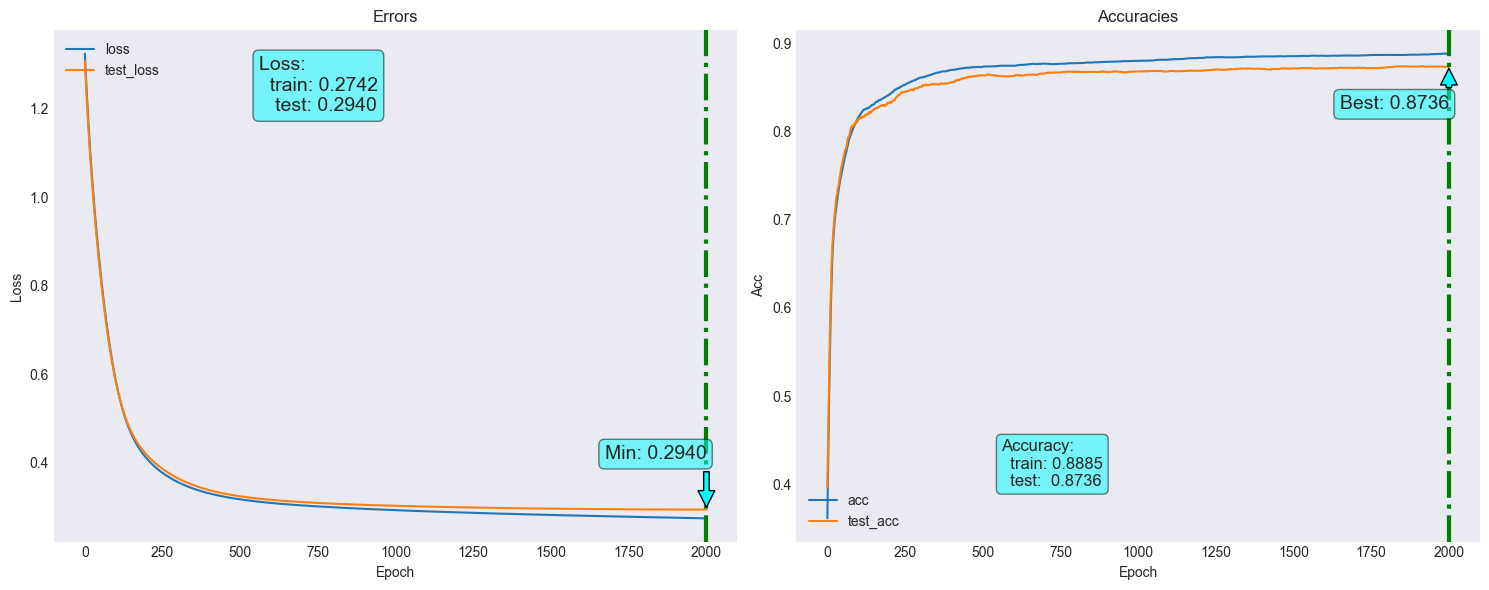

In [25]:
fn_plot_torch_hist(loss_df)

## Training acc, con_mat

In [26]:
## Performance on Train Data

outputs = model(train_X)

y_pred = torch.argmax(outputs, dim = 1).cpu().numpy()

y_pred

array([3, 2, 2, ..., 0, 0, 0], dtype=int64)

In [27]:
print(classification_report(train_y.cpu().numpy(), y_pred ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.92      0.93      0.92      4693
           2       0.84      0.87      0.86      5470
           3       0.86      0.80      0.82      2734

    accuracy                           0.89     14517
   macro avg       0.91      0.90      0.90     14517
weighted avg       0.89      0.89      0.89     14517



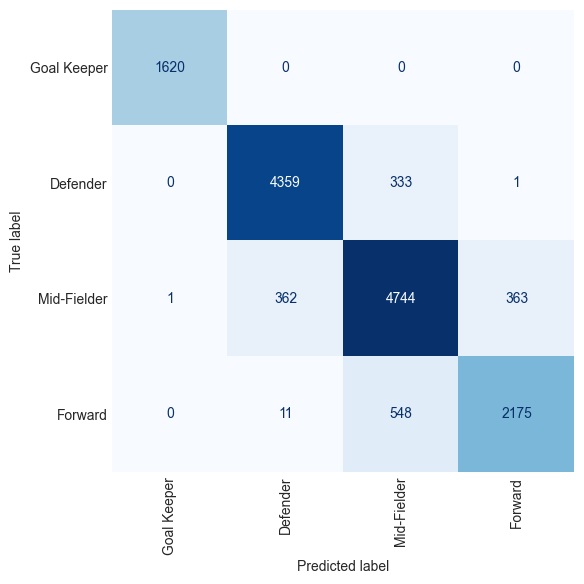

In [28]:
fn_plot_confusion_matrix(train_y.cpu().numpy(), y_pred, labels=labels)

## Testing acc, con_mat

In [29]:
## Performance on Train Data

outputs = model(test_X)

y_pred = torch.argmax(outputs, dim = 1).cpu().numpy()

y_pred

array([2, 2, 3, ..., 2, 2, 1], dtype=int64)

In [30]:
print(classification_report(test_y.numpy(), y_pred ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.92      0.92      0.92      1173
           2       0.82      0.86      0.84      1368
           3       0.83      0.75      0.79       684

    accuracy                           0.87      3630
   macro avg       0.89      0.88      0.89      3630
weighted avg       0.87      0.87      0.87      3630



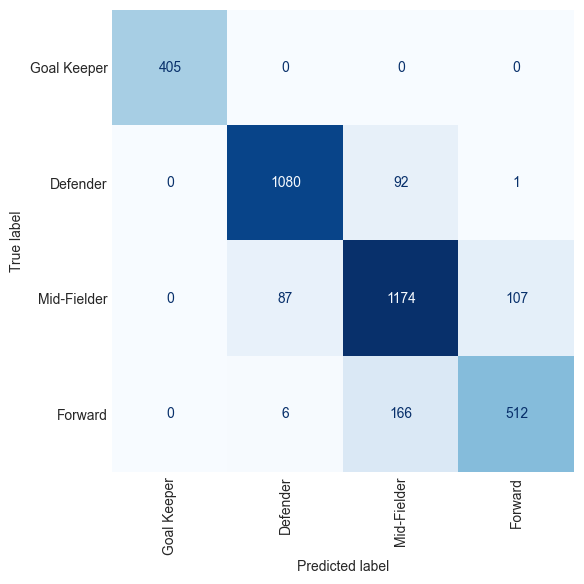

In [31]:
fn_plot_confusion_matrix(test_y.numpy(), y_pred, labels=labels)